## Training Vision Transformer Model

### Index
- [Recreate the ViT-Base Model](#create-the-vit-base-instance)
- [Train my Own ViT-Base Model](#train-my-own-vit-base-model)
- [Use Pretrained ViT Model Weights](#use-pretrained-vit-model)
    - [Create The ViT Feature Extractor Model](#create-the-vit-feature-extractor-model)
    - [Recreate Dataset for the ViT Pretrained](#recreate-dataset-with-same-image-pre-processing-as-vit-base-16-with-torchvisiontransform)
    - [Train the ViT Feature Extractor Model](#train-the-vit-feature-extractor-model)
    - [Prediction on Web Image](#prediction-on-custom-image)

### Add Path of source code file

In [22]:
import sys
import os
from pathlib import Path

def add_top_directory_to_python_path(top_directory : str = "Project"):
    """
    Add top directory of Project to Python Path for managing import between directory

    Args:
        top_directory (str, optional): top folder of project. Defaults to "Project".
    """
    current_dir_path = Path(os.getcwd())
    current_dir_name = current_dir_path.stem
    
    while (current_dir_name != top_directory):
        current_dir_path = current_dir_path.parent
        current_dir_name = current_dir_path.stem
    
    sys.path.append(str(current_dir_path))
    print(f"[INFO] : add [{current_dir_path}] to Python path")

add_top_directory_to_python_path(top_directory="Project")

[INFO] : add [/home/widium/Programming/AI/Vision-Transformer/Project] to Python path


### Load Dataloader

In [2]:
import torch
from pathlib import Path

SAVING_PATH = Path("data/dataset/")

train_dataset_path = SAVING_PATH / "train_dataset.pth"
test_dataset_path = SAVING_PATH / "test_dataset.pth"

train_dataloader = torch.load(f=train_dataset_path)
test_dataloader = torch.load(f=test_dataset_path)

len(train_dataloader), len(test_dataloader)

(8, 3)

## Create the ViT Base Instance
![](https://i.imgur.com/GLaAgax.png)

- Define the Hyperparameters Constante for recreate the ViTBase 

In [3]:
NBR_CLASS = 3
HEIGHT = 224
WIDTH = 224
COLOR = 3
PATCH_SIZE = 16
EMBEDDING = 768
NBR_ENCODER_BLOCK = 12
NBR_HEADS = 12
MLP_UNITS = 3072

In [4]:
from modeling.builder.vit_model import VisionTransformerClassifier

vit_base = VisionTransformerClassifier(
    nbr_classes=NBR_CLASS,
    height=HEIGHT,
    width=WIDTH,
    color_channels=COLOR,
    patch_size=PATCH_SIZE,
    embedding_size=EMBEDDING,
    nbr_encoder_blocks=NBR_ENCODER_BLOCK,
    nbr_heads=NBR_HEADS ,
    mlp_units=MLP_UNITS,
    dropout_embedding=0.1,
    dropout_attention=0.0,
    dropout_mlp=0.1,
)

In [5]:
from torchinfo import summary

summary(model=vit_base, 
        input_size=(1, COLOR, HEIGHT, WIDTH),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
VisionTransformerClassifier (VisionTransformerClassifier)              [1, 3, 224, 224]     [1, 3]               --                   True
├─ImageTokenizer (image_tokenizer)                                     [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─PatchExtractor (patch_extractor)                                [1, 3, 224, 224]     [1, 3, 14, 14]       --                   True
│    │    └─Conv2d (patch_extractor)                                   [1, 3, 224, 224]     [1, 3, 14, 14]       2,307                True
│    └─PatchTokenizer (patch_tokenizer)                                [1, 3, 14, 14]       [1, 196, 3]          --                   --
│    │    └─Flatten (flatten)                                          [1, 3, 14, 14]       [1, 3, 196]          --                   --
│    └─PatchTokenEmbedding

## Train my Own ViT-Base Model
- setup device 

In [9]:
device = "cpu"

vit_base.to(device)
print(f"Using device: {device}")

Using device: cpu


### Create Loss Function, Optimizer and Metrics for Training Loop

- Setup the optimizer with the same configuration as in the paper
with $β1$ = 0.9, $β2$ = 0.999 and weight decay = 0.1

In [7]:
from torch.optim import Adam

optimizer = Adam(
    params=vit_base.parameters(),
    lr=0.001, # 10e-3
    betas=(0.9, 0.999),
    weight_decay=0.1,
)

- Loss Function and Metric Function

In [8]:
from torch.nn import CrossEntropyLoss
from torchmetrics import Accuracy

loss_function = CrossEntropyLoss()
metric_function = Accuracy(task="multiclass", num_classes=NBR_CLASS)

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs            | Train Loss        | Train Accuracy    | Val Loss          | Val Accuracy      |
20.0% [1/5]       | 3.1534            | 0.4492            | 3.0382            | 0.1979            |
-----------------------------------------------------------------------------------------------
40.0% [2/5]       | 1.6586            | 0.2344            | 1.2976            | 0.1979            |
-----------------------------------------------------------------------------------------------
60.0% [3/5]       | 1.4409            | 0.4180            | 2.0727            | 0.1979            |
-----------------------------------------------------------------------------------------------
80.0% [4/5]       | 1.3836            | 0.2852            | 1.1639            | 0.2604            |
-----------------------------------------------------------------------------------------------
100.0% [5/5]      | 1.2031            | 0.2695            | 1.0404            | 0.5417            |
----------------

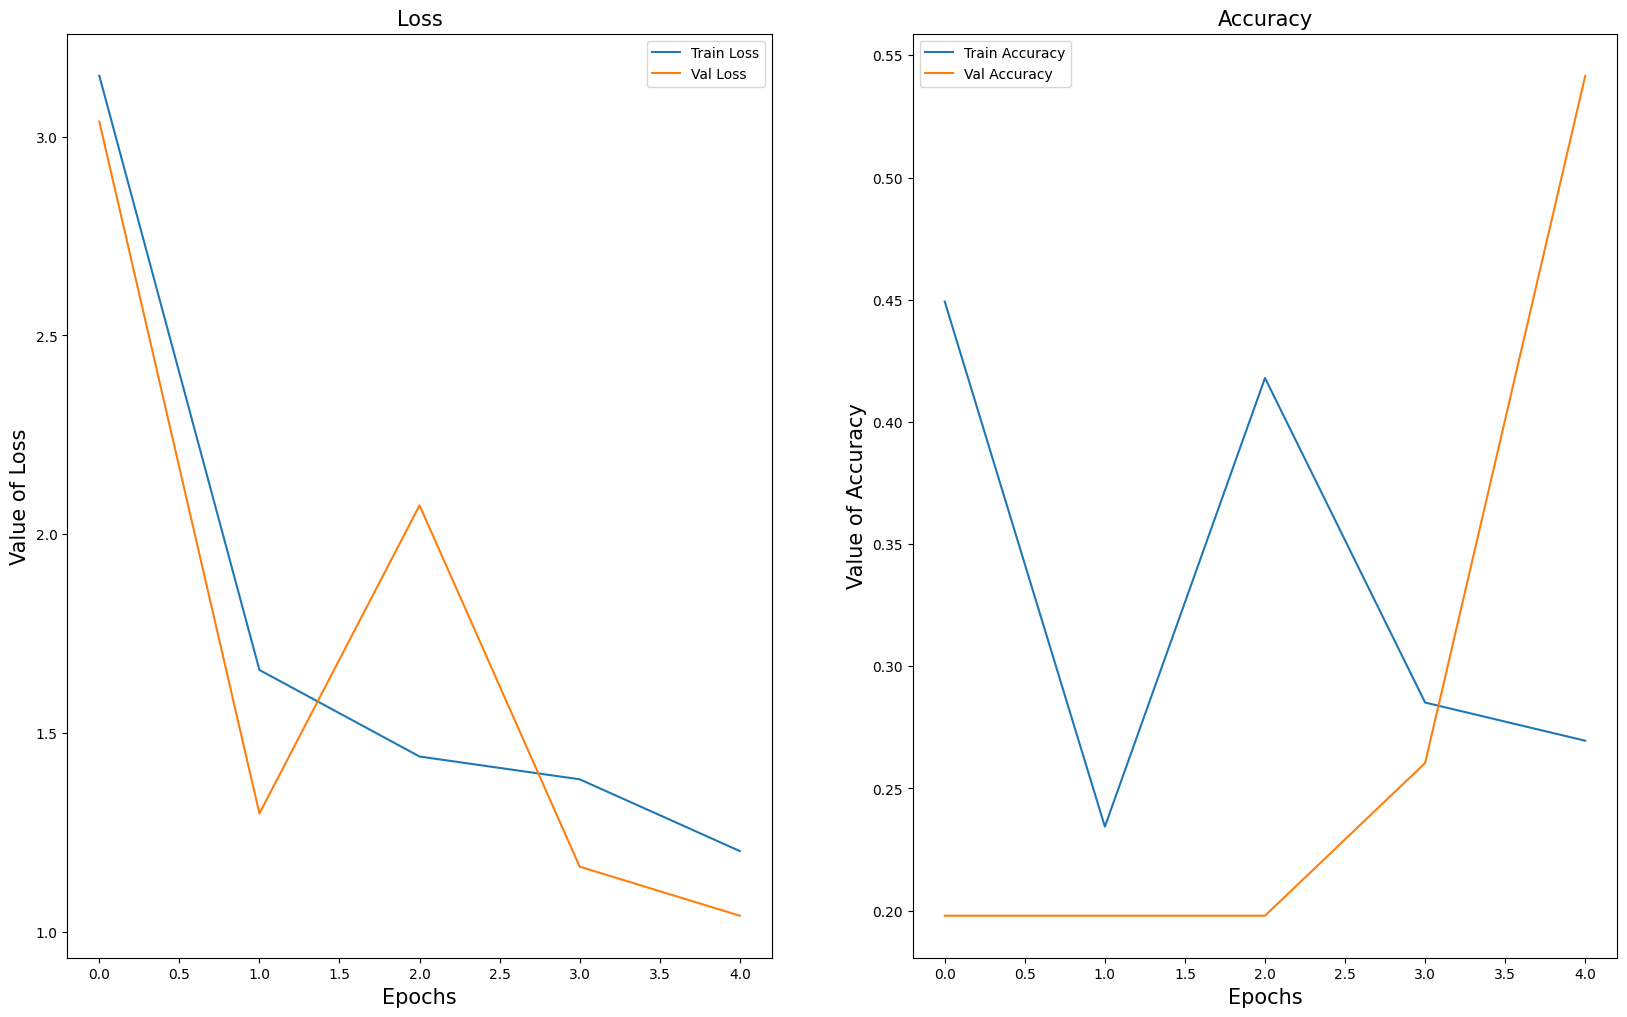

In [10]:
from modeling.training.train import train

history = train(
    model=vit_base,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    metric_function=metric_function,
    device=device,
    epochs=5
)

In [13]:
history.diagnostic_results

{'Bias and UnderFitting': ['High Bias', 'UnderFitting'],
 'Variance and OverFitting': ['Low Variance', 'Good Generalization !'],
 'Last Train Accuracy': '0.270',
 'Last Val Accuracy': '0.542'}

unfortunately the model perform very badly for the following reasons :
- Very small dataset 8 batch of 32 sample (225 sample)
- Lot of Parameters to train with this configuration (85,215,750 parameters)...
- Small computing power, i train this model on my laptop with 32 gb CPU because my GPU have 4 gb...
***
I create all this for learning purpose !

## Use Pretrained ViT Weights !
- For the reasons above i will use pretrained weight with `torchvision` package.
- We will use the `vit_b_16` correspond to 16 `TransformerEncoderBlock` Layer

In [1]:
import torch
import torchvision

print(torch.__version__, torchvision.__version__)

1.13.1 0.14.1


In [7]:
from torchvision.models import ViT_B_16_Weights
from torchvision.models import vit_b_16

vit_weights =  ViT_B_16_Weights.DEFAULT # best available weights
vit_base = vit_b_16(weights=vit_weights) # insert weights inside model instance

In [8]:
from torchinfo import summary

summary(model=vit_base, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

### Create the ViT Feature Extractor Model 
Use transfert Learning techniques to configure this model for my own problem
- Frozen All Parameters 
- Change the `heads` block :
```
├─Sequential (heads)   [1, 768]             [1, 1000]
│    └─Linear (head)   
```
To
```
Linear (head)   [1, 768]             [1, 3]
```


In [9]:
from torch.nn import Module
from torch.nn import Linear

def frozen_module_parameters(module : Module)->Module:
    """Frozen all Module parameters

    Args:
        module (Module): Module

    Returns:
        Module: New Module with all requires_grad = False
    """
    for parameter in module.parameters():
        parameter.requires_grad = False
    
    return (module)


vit_feature_extractor_model = frozen_module_parameters(module=vit_base)
vit_feature_extractor_model.heads = Linear(in_features=768, out_features=3)

In [10]:
from torchinfo import summary

summary(model=vit_feature_extractor_model, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

Now we just have `Trainable params: 2,307` 

### Recreate dataset with same image pre-processing as ViT-Base-16 with (`torchvision.transform`) 

In [12]:
preprocessing = vit_weights.transforms()

preprocessing

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [13]:
from pathlib import Path

PARENT_FOLDER = Path("data/pizza_steak_sushi/")
TRAIN_DIR = PARENT_FOLDER / "train"
TEST_DIR = PARENT_FOLDER / "test"

PARENT_FOLDER, TRAIN_DIR, TEST_DIR

(PosixPath('data/pizza_steak_sushi'),
 PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [14]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root=TRAIN_DIR,
                            transform=preprocessing)

test_dataset = ImageFolder(root=TEST_DIR,
                           transform=preprocessing)

len(train_dataset), len(test_dataset)

(225, 75)

In [15]:
from torch.utils.data import DataLoader
import os 

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True 
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False # don't necessarily have to shuffle the testing data
)

len(train_dataloader), len(test_dataloader)

(8, 3)

### Setup optimizer, loss function and metric function

In [17]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchmetrics import Accuracy

optimizer = Adam(params=vit_feature_extractor_model.parameters(), lr=0.001)
loss_function = CrossEntropyLoss()
metric_function = Accuracy(task="multiclass", num_classes=3)

### Train the ViT Feature Extractor Model

In [20]:
device = "cuda"

vit_base.to(device)
print(f"Using device: {device}")

Using device: cuda


  0%|          | 0/5 [00:00<?, ?it/s]

Epochs            | Train Loss        | Train Accuracy    | Val Loss          | Val Accuracy      |
20.0% [1/5]       | 0.7092            | 0.7891            | 0.5149            | 0.8267            |
-----------------------------------------------------------------------------------------------
40.0% [2/5]       | 0.2990            | 0.9570            | 0.3325            | 0.8674            |
-----------------------------------------------------------------------------------------------
60.0% [3/5]       | 0.2364            | 0.9609            | 0.2638            | 0.8977            |
-----------------------------------------------------------------------------------------------
80.0% [4/5]       | 0.2203            | 0.9648            | 0.2120            | 0.8977            |
-----------------------------------------------------------------------------------------------
100.0% [5/5]      | 0.1213            | 0.9688            | 0.2278            | 0.9081            |
----------------

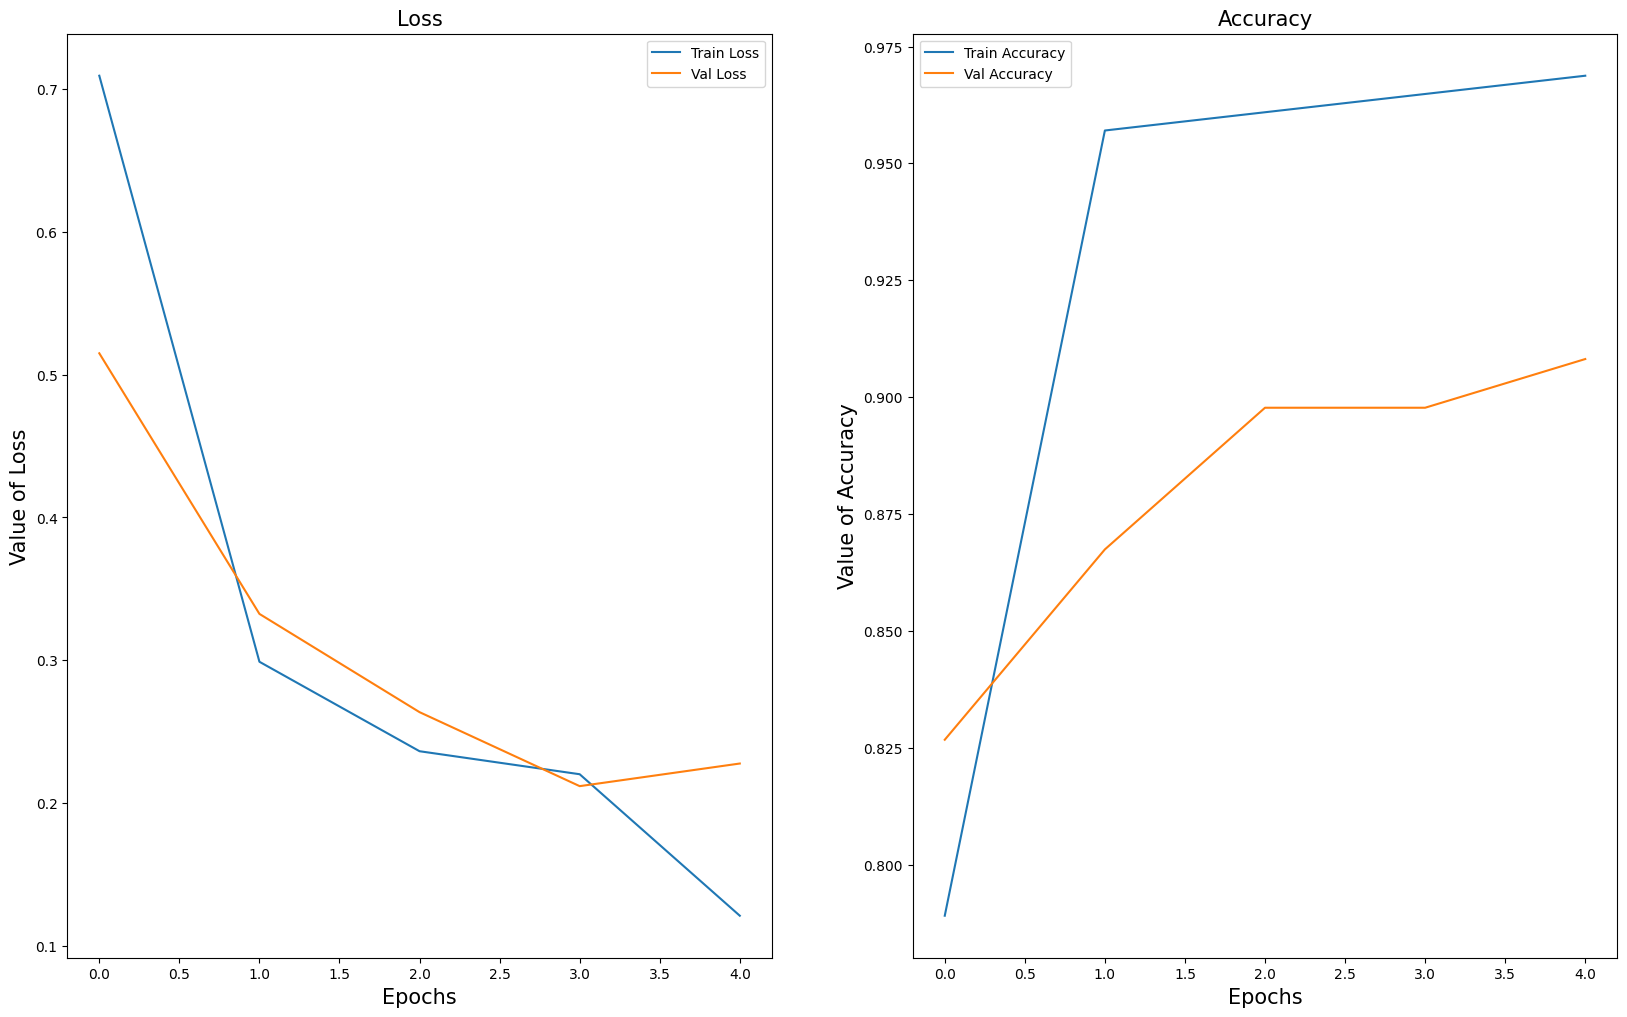

In [21]:
from modeling.training.train import train

history = train(
    model=vit_base,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    metric_function=metric_function,
    device=device,
    epochs=5
)

### Prediction on custom image

In [26]:
from typing import List
import matplotlib.pyplot as plt

import torch
from torch.nn import Module
from torchvision.transforms import Compose

from PIL import Image

from modeling.utils.logits import logits_to_class_integer, logits_to_probs

def inference_image_classification(
    model : Module,
    img_path : str,
    pipeline : Compose,
    class_names : List[str] = None
)->None:
    """Make Classification Prediction on Custom Image 

    Create Batch Image with same Transformer of Test Set
    Generate Probability and Class Name of Prediction
    
    Args:
        model (Module): ttrained model
        img_path (str): img filename
        pipeline (Compose): Image Transformer of Test Set
        class_names (List[str], optional): Human-Readable Labeling. Defaults to None.
    """
    image = Image.open(img_path)
    tensor_img = pipeline(image)
    batch_tensor_img = tensor_img.unsqueeze(dim=0)

    model.eval()

    with torch.inference_mode():

        logits = model(batch_tensor_img)
        probs = logits_to_probs(logits)
        y_pred = logits_to_class_integer(logits)

    if class_names:
        title = f"Predict : {class_names[y_pred]} with {probs:.2f}%"
    else :
        title = f"Predict Class {y_pred.item()} with {probs:.2f}"

    plt.imshow(image)
    plt.title(title)
    plt.axis("off")

In [28]:
import wget 

def download_web_image(
    url : str,
    filename : str = "web_image", 
    destination : str = "../modeling/data",
):
    img_destination = Path(destination) / f"{filename}.png"

    if img_destination.exists():
        print(f"[ERROR] : File {filename} already exist in {img_destination}...")
        return (img_destination)
    else :
        img_path = wget.download(url)
        moved_file_path = Path(img_path).rename(img_destination)
        print(f"[INFO] : Move {img_path} here : {moved_file_path}")
        return (moved_file_path)

In [30]:
download_web_image(
    url="https://cuisine.land/upload/recettes/large/53_MQGWWFCAA400CKDU.jpg",
    filename="web_sushi_image",
    destination="data/",
)

[INFO] : Move 53_MQGWWFCAA400CKDU.jpg here : data/web_sushi_image.png


PosixPath('data/web_sushi_image.png')

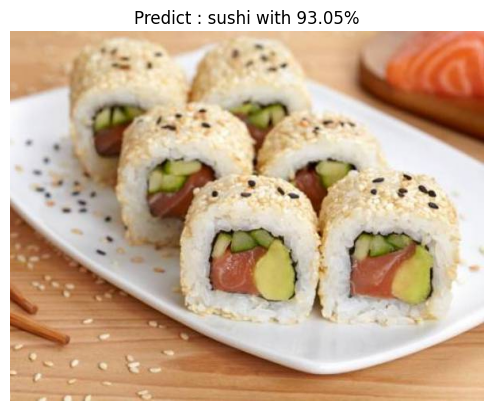

In [32]:
vit_feature_extractor_model.to("cpu")

inference_image_classification(
    model=vit_feature_extractor_model,
    img_path='data/web_sushi_image.png',
    pipeline=preprocessing,
    class_names=train_dataset.classes
)